In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Data sets

Data collected from https://catalog.data.gov/dataset?res_format=CSV&tags=weather and https://www.bgc-jena.mpg.de/index.php/Main/HomePage

zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

df = pd.read_csv(csv_path)

In [2]:
df = pd.read_csv(r'https://data.townofcary.org/api/v2/catalog/datasets/rdu-weather-history/exports/csv', sep=';')

In [3]:
df.shape

(4830, 28)

In [4]:
df.head()

,date,temperaturemin,temperaturemax,precipitation,snowfall,snowdepth,avgwindspeed,fastest2minwinddir,fastest2minwindspeed,fastest5secwinddir,...,drizzle,snow,freezingrain,smokehaze,thunder,highwind,hail,blowingsnow,dust,freezingfog
0,2011-09-07,69.1,82.9,0.00,0.0,0.0,3.80,180.0,14.99,230.0,...,No,No,No,No,No,No,No,No,No,No
1,2011-09-09,63.0,84.9,0.00,0.0,0.0,3.80,170.0,12.08,170.0,...,No,No,No,No,No,No,No,No,No,No
2,2011-09-14,66.0,89.1,0.00,0.0,0.0,2.46,230.0,12.08,220.0,...,No,No,No,No,No,No,No,No,No,No
3,2011-09-22,70.0,82.0,0.08,0.0,0.0,2.46,230.0,8.95,220.0,...,Yes,No,No,No,Yes,No,No,No,No,No
4,2011-09-25,70.0,80.1,0.00,0.0,0.0,5.82,150.0,17.90,170.0,...,Yes,No,No,No,No,No,No,No,No,No


In [5]:
df.isnull().sum()

date                     0
temperaturemin           1
temperaturemax           1
precipitation            1
snowfall                 1
snowdepth                1
avgwindspeed             2
fastest2minwinddir       1
fastest2minwindspeed     1
fastest5secwinddir      18
fastest5secwindspeed    18
fog                      0
fogheavy                 0
mist                     0
rain                     0
fogground                0
ice                      0
glaze                    0
drizzle                  0
snow                     0
freezingrain             0
smokehaze                0
thunder                  0
highwind                 0
hail                     0
blowingsnow              0
dust                     0
freezingfog              0
dtype: int64

In [6]:
df.fillna(method='ffill', inplace=True)

In [7]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [8]:
TRAIN_SPLIT = 3000

In [9]:
tf.random.set_seed(13) #in order to reproduce

In [10]:
uni_data = df['temperaturemax']
uni_data.index = df['date']
uni_data.head()

date
2011-09-07    82.9
2011-09-09    84.9
2011-09-14    89.1
2011-09-22    82.0
2011-09-25    80.1
Name: temperaturemax, dtype: float64

In [11]:
# uni_data = df['T (degC)']
# uni_data.index = df['Date Time']
# uni_data.head()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000025504538550>],
      dtype=object)

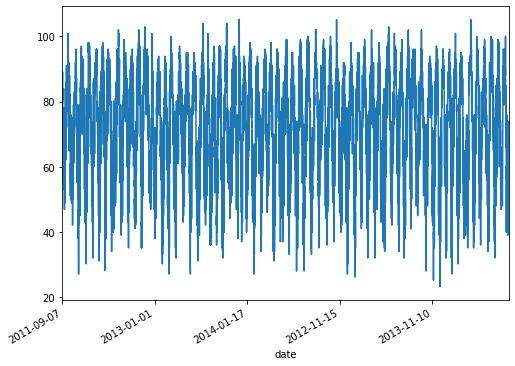

In [12]:
uni_data.plot(subplots=True)

In [13]:
uni_data = uni_data.values

scale features 

In [14]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_train_std

16.397834749712807

standardize the data

In [15]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [16]:
uni_data.shape

(4830,)

In [17]:
univariate_past_history = 20 #look into the past how far
univariate_future_target = 0 #what day to predict next day zero

In [18]:
#split data
x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [18]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-0.06826664]
 [-1.04709429]
 [ 0.10196425]
 [ 0.10196425]
 [-1.47267153]
 [-1.89824877]
 [-1.41795446]
 [-0.49992356]
 [-1.41795446]
 [-1.47267153]
 [-0.49992356]
 [-1.35107804]
 [-1.47267153]
 [ 0.04724718]
 [-1.04709429]
 [-0.6823138 ]
 [-0.32361299]
 [-0.13514307]
 [ 0.53362117]
 [-1.41795446]]

 Target temperature to predict
-0.5607203053408737


In [19]:
def create_time_steps(length):
  return list(range(-length, 0))

In [20]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

Example of what we are attemping to predict vs acutall

<module 'matplotlib.pyplot' from 'C:\\Users\\cgree\\.conda\\envs\\keras-gpu\\lib\\site-packages\\matplotlib\\pyplot.py'>

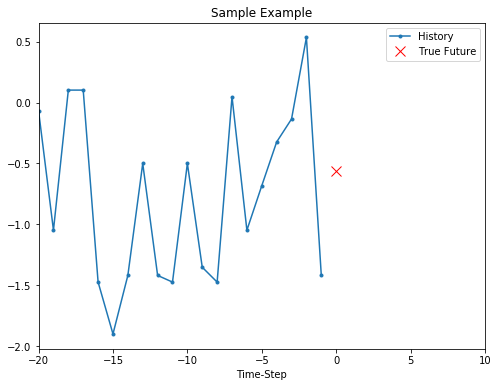

In [21]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

let's first set a simple baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 20 observations.

Benchmark

In [22]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from 'C:\\Users\\cgree\\.conda\\envs\\keras-gpu\\lib\\site-packages\\matplotlib\\pyplot.py'>

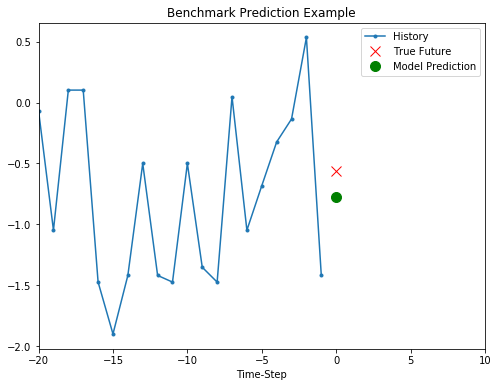

In [23]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Benchmark Prediction Example')

Let's see if you can beat this baseline using a recurrent neural network.

In [24]:
BATCH_SIZE = 50
BUFFER_SIZE = 100

In [25]:
#shuffle data --- every day im suffling
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

#### Model
LSTM requires the input shape of the data it is being given.

In [26]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [27]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(50, 1)


In [28]:
EVALUATION_INTERVAL = 30 #epoch will only run for 30 steps - set back to one
EPOCHS = 10

In [29]:


simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 30 steps, validate for 50 steps
Epoch 1/10
30/30 [==============================] - 2s 83ms/step - loss: 0.7767 - val_loss: 0.7276
Epoch 2/10
30/30 [==============================] - 0s 8ms/step - loss: 0.6824 - val_loss: 0.6564
Epoch 3/10
30/30 [==============================] - 0s 7ms/step - loss: 0.6336 - val_loss: 0.6055
Epoch 4/10
30/30 [==============================] - 0s 6ms/step - loss: 0.5753 - val_loss: 0.5644
Epoch 5/10
30/30 [==============================] - 0s 6ms/step - loss: 0.5495 - val_loss: 0.5313
Epoch 6/10
30/30 [==============================] - 0s 7ms/step - loss: 0.5089 - val_loss: 0.5034
Epoch 7/10
30/30 [==============================] - 0s 7ms/step - loss: 0.4928 - val_loss: 0.4801
Epoch 8/10
30/30 [==============================] - 0s 7ms/step - loss: 0.4599 - val_loss: 0.4639
Epoch 9/10
30/30 [==============================] - 0s 6ms/step - loss: 0.4600 - val_loss: 0.4580
Epoch 10/10
30/30 [==============================] - 0s 7ms/step - loss: 0.

Predicted : [-0.9045734]
Actual : -1.7097788523156936


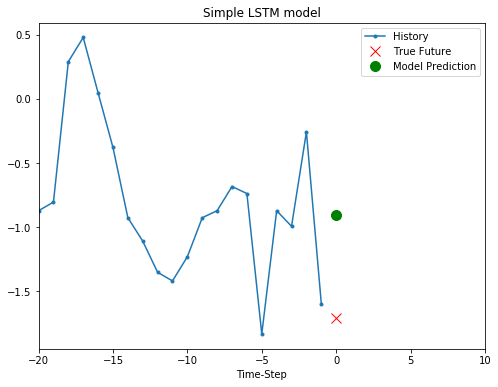

Predicted : [-0.5339505]
Actual : -1.4726715330986673


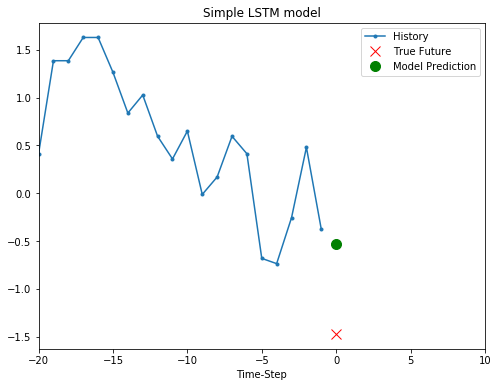

Predicted : [1.1654103]
Actual : 1.6279626412778312


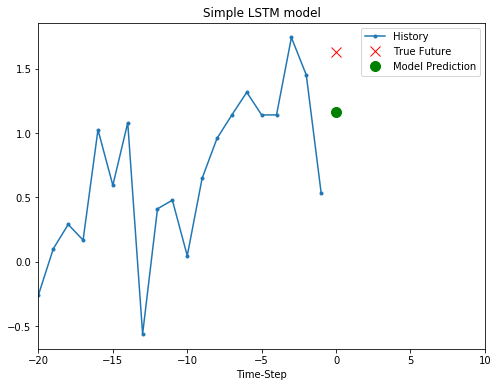

In [135]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  print('Predicted : {}'.format(simple_lstm_model.predict(x)[0]))
  print('Actual : {}'.format(y[0]))
  plot.show()

looks better than the baseline. Now that you have seen the basics, let's move on to part two, where you will work with a multivariate time series.

### multivariate time series

In [31]:
df.columns

Index(['date', 'temperaturemin', 'temperaturemax', 'precipitation', 'snowfall',
       'snowdepth', 'avgwindspeed', 'fastest2minwinddir',
       'fastest2minwindspeed', 'fastest5secwinddir', 'fastest5secwindspeed',
       'fog', 'fogheavy', 'mist', 'rain', 'fogground', 'ice', 'glaze',
       'drizzle', 'snow', 'freezingrain', 'smokehaze', 'thunder', 'highwind',
       'hail', 'blowingsnow', 'dust', 'freezingfog'],
      dtype='object')

In [185]:
features_considered=[ 'precipitation','temperaturemax', 'avgwindspeed']

In [186]:
features = df[features_considered]
features.index = df['date']
features.head()

,precipitation,temperaturemax,avgwindspeed
date,,,
2007-01-06,0.13,71.1,8.05
2007-01-09,0.00,55.0,7.61
2007-01-14,0.00,73.9,8.50
2007-01-15,0.00,73.9,13.20
2007-01-20,0.00,48.0,4.92


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001F599363DA0>,
      dtype=object)

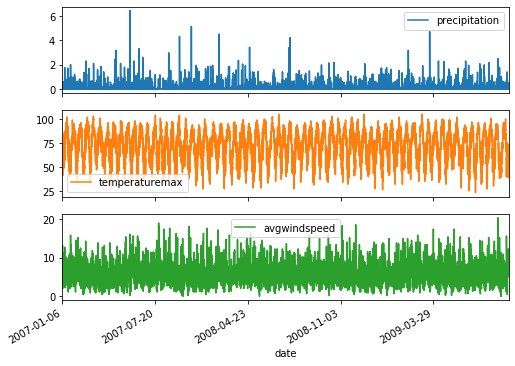

In [187]:
features.plot(subplots=True)

scaling/standardize

In [188]:
features.values

array([[1.30e-01, 7.11e+01, 8.05e+00],
       [0.00e+00, 5.50e+01, 7.61e+00],
       [0.00e+00, 7.39e+01, 8.50e+00],
       ...,
       [4.70e-01, 4.30e+01, 6.49e+00],
       [1.00e-02, 5.31e+01, 7.61e+00],
       [0.00e+00, 4.69e+01, 7.61e+00]])

In [189]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
data_std

array([ 0.38818517, 16.44824805,  2.89586832])

In [190]:
dataset = (dataset-data_mean)/data_std

In [191]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

the model will be given the last 20 recorded temperature observations, and needs to learn` to predict the temperature at the next time step.

In [192]:
past_history = 30 #past 30 days
future_target = 2 #what day to predict
STEP = 3 #adjustment for iterations/steps similar to epocks

In [193]:

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [194]:
y_train_single

array([ 0.90448133,  0.47890409,  0.64913499, ..., -0.56072031,
       -0.87078372, -0.8039073 ])

In [195]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (10, 3)


In [196]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [197]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [198]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(50, 1)


Train model

In [199]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 30 steps, validate for 50 steps
Epoch 1/10
30/30 [==============================] - 2s 69ms/step - loss: 0.6841 - val_loss: 0.5843
Epoch 2/10
30/30 [==============================] - 0s 6ms/step - loss: 0.5473 - val_loss: 0.5178
Epoch 3/10
30/30 [==============================] - 0s 6ms/step - loss: 0.5120 - val_loss: 0.5024
Epoch 4/10
30/30 [==============================] - 0s 7ms/step - loss: 0.4907 - val_loss: 0.5046
Epoch 5/10
30/30 [==============================] - 0s 6ms/step - loss: 0.4986 - val_loss: 0.4958
Epoch 6/10
30/30 [==============================] - 0s 6ms/step - loss: 0.4875 - val_loss: 0.4939
Epoch 7/10
30/30 [==============================] - 0s 7ms/step - loss: 0.4956 - val_loss: 0.4913
Epoch 8/10
30/30 [==============================] - 0s 6ms/step - loss: 0.4797 - val_loss: 0.5048
Epoch 9/10
30/30 [==============================] - 0s 7ms/step - loss: 0.4906 - val_loss: 0.4906
Epoch 10/10
30/30 [==============================] - 0s 7ms/step - loss: 0.

In [200]:
'''Plot the train/validation loss against on another'''
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

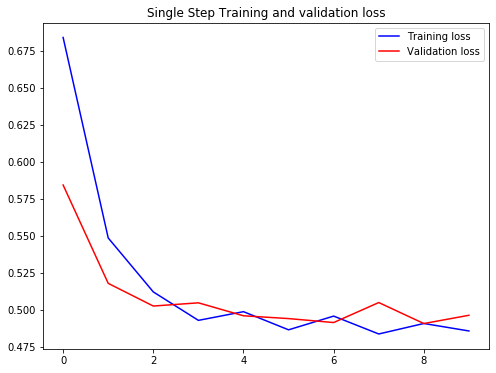

In [201]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

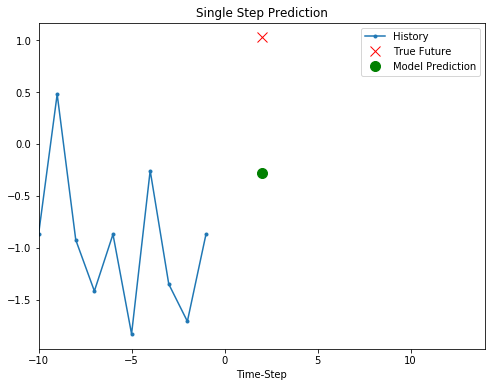

Predicted : [-0.28087044]
Actual : 1.026074830957687


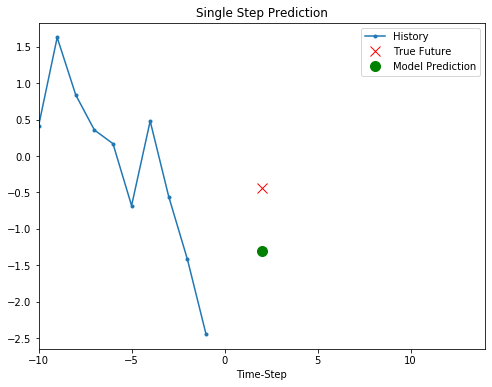

Predicted : [-1.3042586]
Actual : -0.4452064831582194


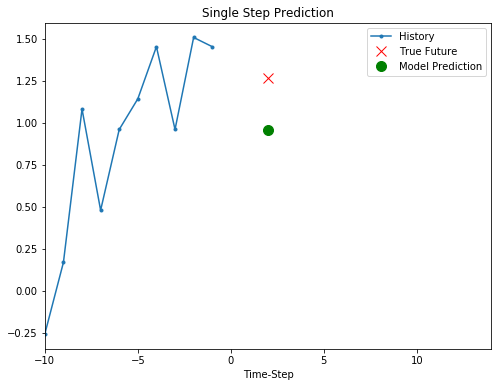

Predicted : [0.95896506]
Actual : 1.2631821501747138


In [202]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], (2),
                   'Single Step Prediction')
  plot.show()
  print('Predicted : {}'.format(single_step_model.predict(x)[0]))
  print('Actual : {}'.format(y[0]))

### Predict a range of future values

In [203]:
future_target = 5 #samples from the last 5 days

In [204]:
#split data 
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [205]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (10, 3)

 Target temperature to predict : (5,)


In [206]:
#tf.data to shuffle, batch, and cache the dataset.
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [207]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

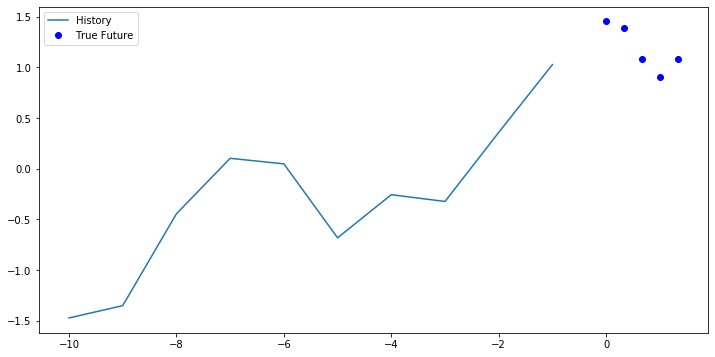

In [208]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

Model

In [209]:
import datetime

In [210]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(5))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae',metrics=['accuracy'])

log_dir = r"C:\Users\cgree\Documents\logs\fit" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [211]:
for x, y in val_data_multi.take(1):
  print(multi_step_model.predict(x).shape)
  print(y.shape)

(50, 5)
(50, 5)


In [212]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50,
                                          callbacks=[tensorboard_callback])

Train for 30 steps, validate for 50 steps
Epoch 1/10
30/30 [==============================] - 5s 157ms/step - loss: 0.7975 - accuracy: 0.1973 - val_loss: 0.7469 - val_accuracy: 0.2144
Epoch 2/10
30/30 [==============================] - 1s 21ms/step - loss: 0.7031 - accuracy: 0.2082 - val_loss: 0.6381 - val_accuracy: 0.1974
Epoch 3/10
30/30 [==============================] - 1s 20ms/step - loss: 0.5972 - accuracy: 0.1860 - val_loss: 0.5739 - val_accuracy: 0.1942
Epoch 4/10
30/30 [==============================] - 1s 21ms/step - loss: 0.5595 - accuracy: 0.2088 - val_loss: 0.5368 - val_accuracy: 0.2346
Epoch 5/10
30/30 [==============================] - 1s 21ms/step - loss: 0.5305 - accuracy: 0.2200 - val_loss: 0.5296 - val_accuracy: 0.2402
Epoch 6/10
30/30 [==============================] - 1s 20ms/step - loss: 0.5124 - accuracy: 0.2463 - val_loss: 0.5183 - val_accuracy: 0.2681
Epoch 7/10
30/30 [==============================] - 1s 21ms/step - loss: 0.5116 - accuracy: 0.2453 - val_loss: 

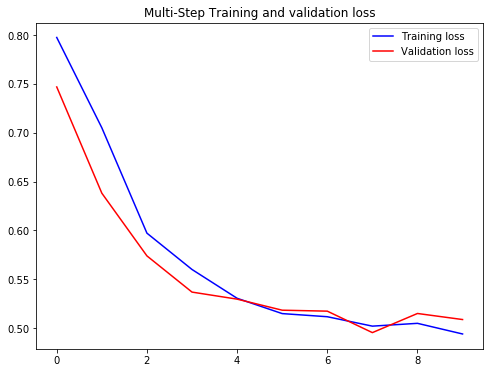

In [213]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

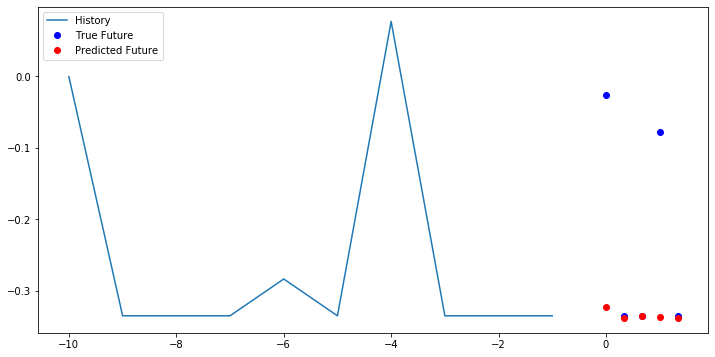

Predicted : [-0.32329106 -0.33817482 -0.33541733 -0.3361282  -0.3376274 ]
Actual : [-0.02598416 -0.33511498 -0.33511498 -0.07750597 -0.33511498]
Difference : [-0.2973069  -0.00305984 -0.00030235 -0.25862224 -0.00251243]


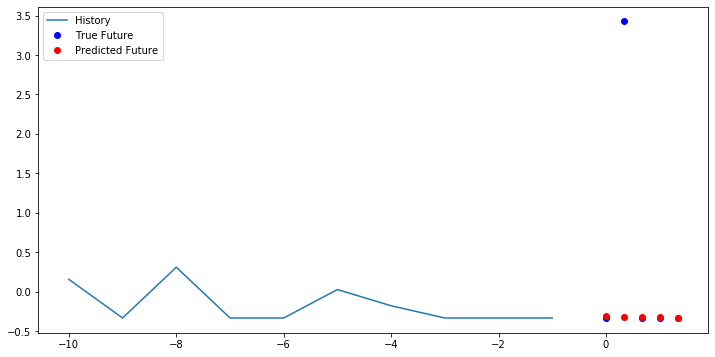

Predicted : [-0.31252977 -0.32286304 -0.32561427 -0.3272756  -0.32916096]
Actual : [-0.33511498  3.42597667 -0.33511498 -0.33511498 -0.33511498]
Difference : [ 0.02258521 -3.74883971  0.00950071  0.00783938  0.00595402]


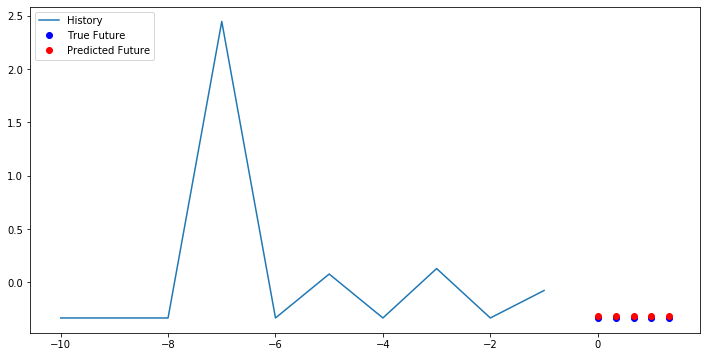

Predicted : [-0.32033613 -0.31756923 -0.32003695 -0.319046   -0.31906712]
Actual : [-0.33511498 -0.33511498 -0.33511498 -0.33511498 -0.33511498]
Difference : [0.01477885 0.01754576 0.01507804 0.01606899 0.01604786]


In [133]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])
  print('Predicted : {}'.format(multi_step_model.predict(x)[0]))
  print('Actual : {}'.format(y[0]))
  print('Difference : {}'.format(multi_step_model.predict(x)[0]-(y[0])))

In [95]:
def R_squared(y, y_pred):
    
  residual = tf.reduce_sum(tf.square(tf.subtract(y,y_pred)))
  total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
  r2 = tf.subtract(1.0, tf.div(residual, total))
  return r2